In [1]:
# import relevant modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
input_data_path = 'data/'
transactions = pd.read_csv(f'{input_data_path}/fe_data.csv')

In [3]:
transactions = transactions.drop(columns=['nan', 'errors']).set_index('transaction_id')

transactions = pd.get_dummies(transactions, drop_first=True, dtype=int)

transactions.to_csv(f'{input_data_path}/model_data_v2.csv')

In [4]:
transactions = transactions.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=42))

C:\Users\user\AppData\Local\Temp\ipykernel_56860\3466682050.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions = transactions.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.5, random_state=42))


In [5]:
target = 'target'

In [6]:
transactions.columns = transactions.columns.str.replace(',', '_')

In [7]:
# feature engineering
# set random seed
seed = 42
# treat categorical variables
transactions = pd.get_dummies(transactions, drop_first=True, dtype=int)
# randomly shuffle the data
transactions = transactions.sample(frac=1, random_state=seed)
# create features X and target y
#X = transactions.drop(columns=[target])
#y = transactions[target]
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(transactions.drop(columns=[target]), transactions[target], test_size=0.2, random_state=seed)
# initialize a standard scaler
#scaler = StandardScaler()
# fit and transform the training data
#X_train_scaled = scaler.fit_transform(X_train)
# transform the test data
#X_test_scaled = scaler.transform(X_test)
# convert both scaled data to dataframes
#X_train_scaled = pd.DataFrame(X_train_scaled, columns=scaler.get_feature_names_out(), index=y_train.index)
#X_test_scaled = pd.DataFrame(X_test_scaled, columns=scaler.get_feature_names_out(), index=y_test.index)

In [8]:
# Train a Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=5, random_state=seed)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

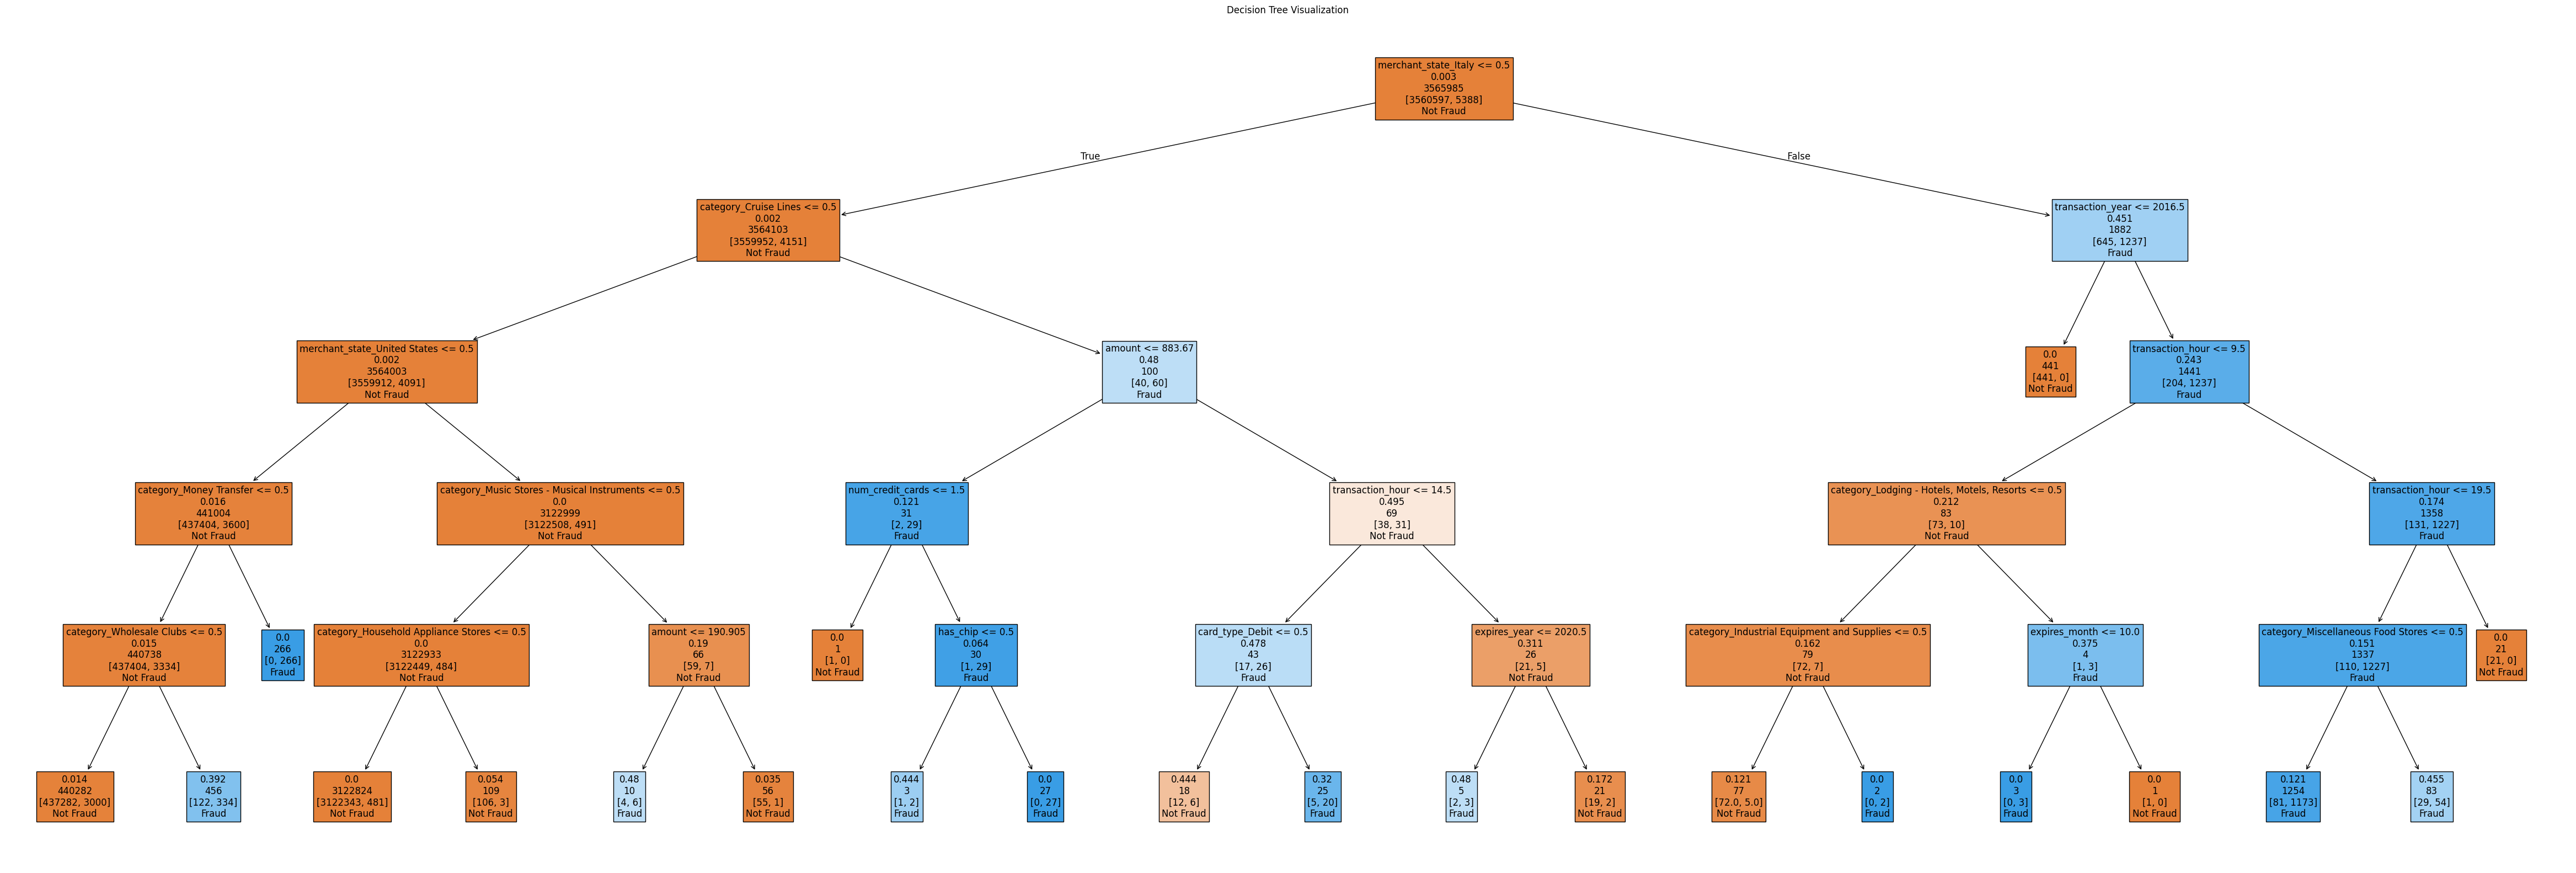

In [9]:
# plot the tree
plt.figure(figsize=(60, 20))
plot_tree(dt_model, feature_names=X_train.columns, class_names=["Not Fraud", "Fraud"], label='none', filled=True, fontsize=12)
plt.title("Decision Tree Visualization")
#plt.savefig('initialDecisionTree', dpi = 300)
plt.show()

In [10]:
# create a function that generates the classification report,
# visualizes the confusion matrix, and calculates the expected ROI for a given model
def model_evaluation_function(model, X_test, y_test, confusion_matrix_title='Model'):
    '''
    Evaluate model (model metrics and ROI)

    Args:
    model: The sklearn classification model
    X_test: Predictors of the test set
    y_test: Actual target values of the test set
    confusion_matrix_title: Title of the confusion matrix

    Returns:
    None
    '''

    # make predictions on the test set
    y_pred = model.predict(X_test)
    # print classification report
    print(f'Classification report: \n{classification_report(y_test, y_pred)}\n')

    # calculate and print evaluation metrics
    conf_mat = confusion_matrix(y_test, y_pred)
    tn = conf_mat[0][0]
    fp =  conf_mat[0][1]
    fn = conf_mat[1][0]
    tp = conf_mat[1][1]

    pcc = (tn + tp) / (tn + fp + fn + tp)
    false_alarm_rate = fp / (tn + fp)
    false_dismissal_rate = fn / (fn + tp)
    precision = tp / (tp + fp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f"""Evaluation metrics:\nThe PCC is {pcc:.4f}\nThe false alarm rate is {false_alarm_rate:.4f}\nThe false dismissal rate is {false_dismissal_rate:.4f}\nThe precision is {precision:.4f}\nThe sensitivity is {sensitivity:.4f} and\nThe specificity is {specificity:.4f}""")

    # show the confusion matrix in a heat map
    labels = ['Not fraud', 'Fraud']
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Blues_r', cbar=False, 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{confusion_matrix_title} Confusion Matrix')
    plt.show()

    return y_pred

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    890219
         1.0       0.87      0.33      0.48      1278

    accuracy                           1.00    891497
   macro avg       0.93      0.66      0.74    891497
weighted avg       1.00      1.00      1.00    891497


Evaluation metrics:
The PCC is 0.9990
The false alarm rate is 0.0001
The false dismissal rate is 0.6706
The precision is 0.8663
The sensitivity is 0.3294 and
The specificity is 0.9999


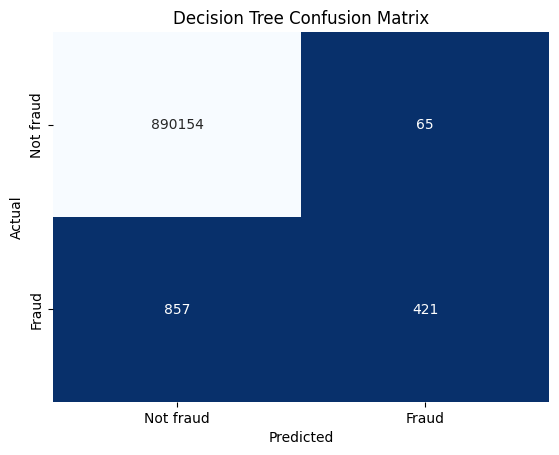

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
# evaluate the decision tree model
model_evaluation_function(model=dt_model, X_test=X_test, y_test=y_test, confusion_matrix_title='Decision Tree')

In [12]:
# Train a Decision Tree Classifier
dt_model2 = DecisionTreeClassifier(max_depth=5, random_state=seed, min_samples_split =2, min_samples_leaf = 5, criterion='entropy',
                                  class_weight='balanced')
dt_model2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=5, random_state=42)

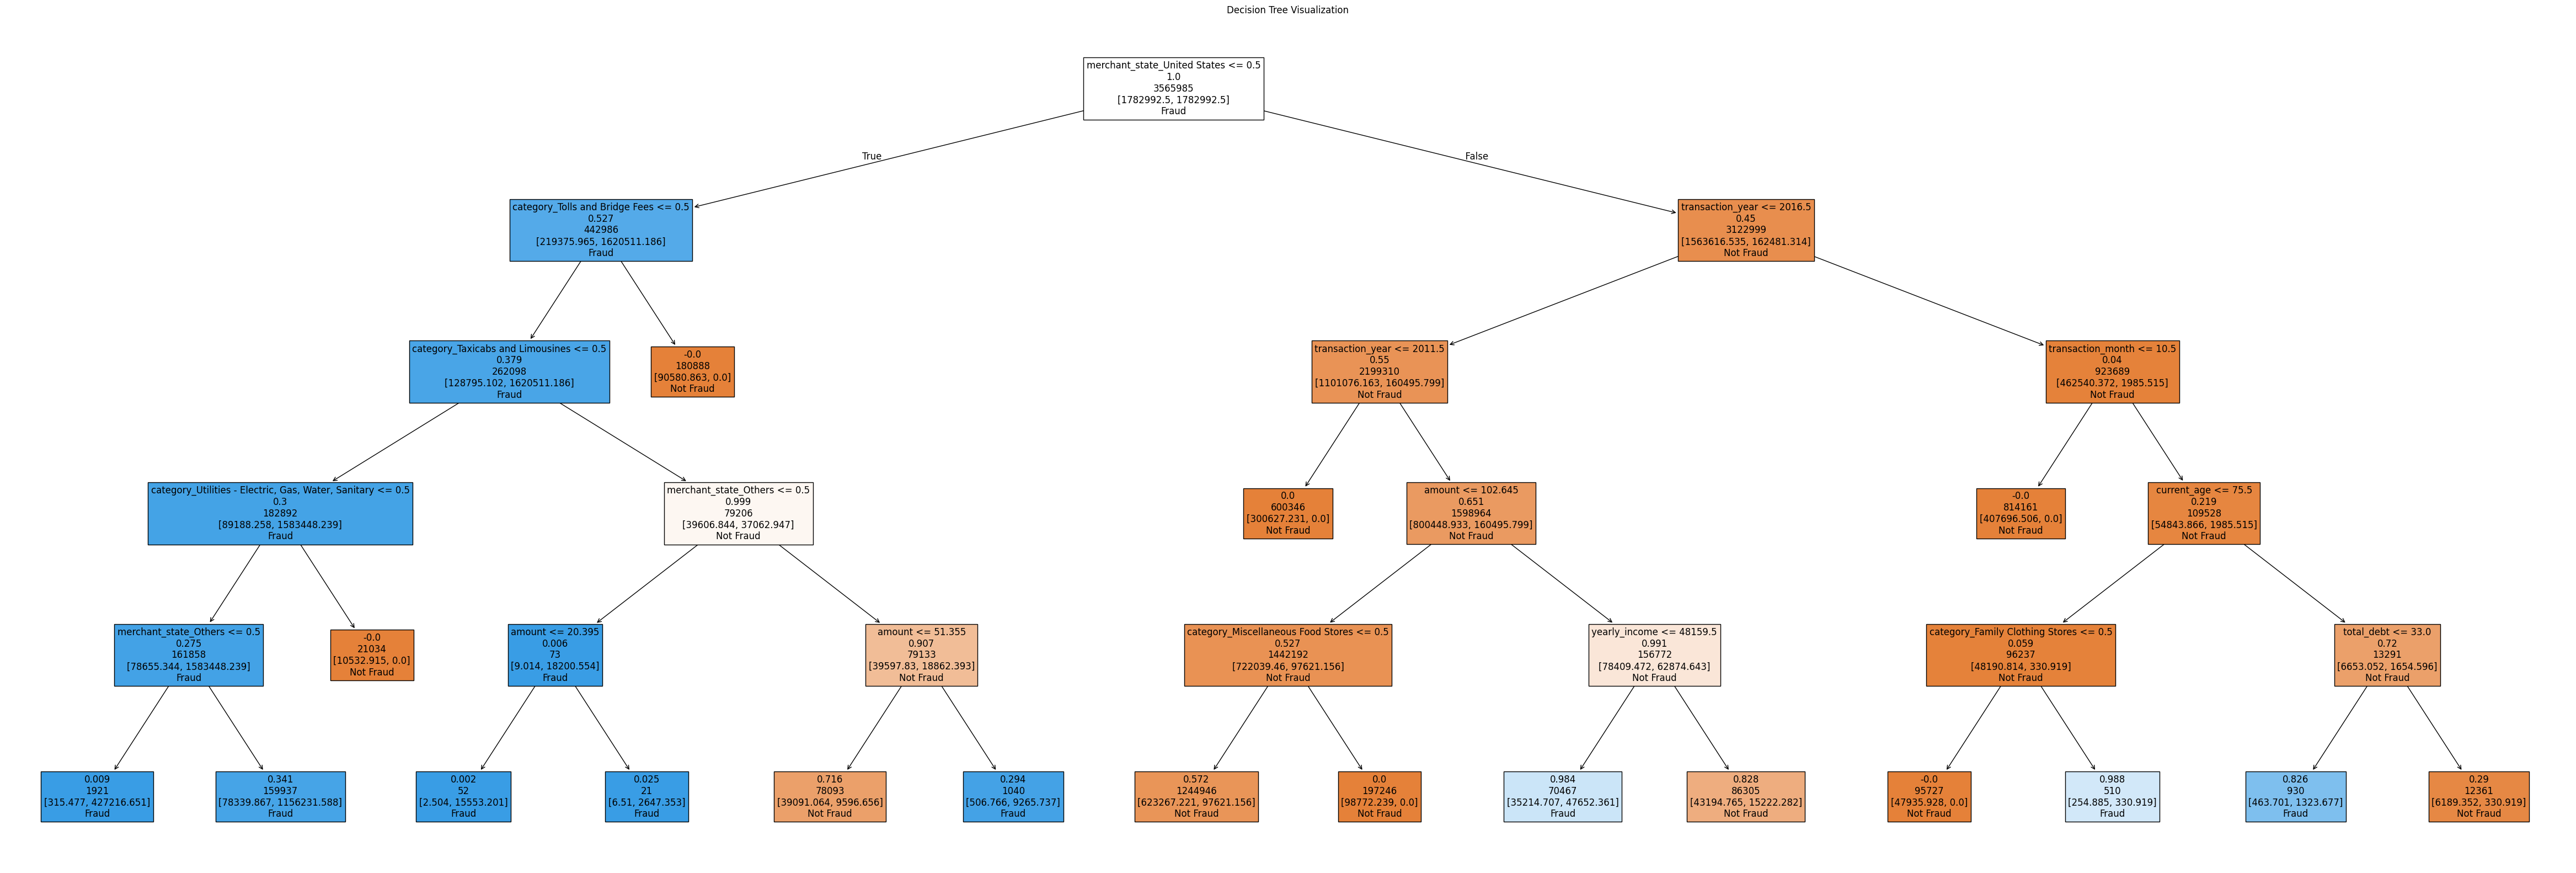

In [13]:
# plot the tree
plt.figure(figsize=(60, 20))
plot_tree(dt_model2, feature_names=X_train.columns, class_names=["Not Fraud", "Fraud"], label='none', filled=True, fontsize=12)
plt.title("Decision Tree Visualization")
#plt.savefig('initialDecisionTree', dpi = 300)
plt.show()

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97    890219
         1.0       0.02      0.93      0.04      1278

    accuracy                           0.94    891497
   macro avg       0.51      0.93      0.50    891497
weighted avg       1.00      0.94      0.97    891497


Evaluation metrics:
The PCC is 0.9354
The false alarm rate is 0.0646
The false dismissal rate is 0.0720
The precision is 0.0202
The sensitivity is 0.9280 and
The specificity is 0.9354


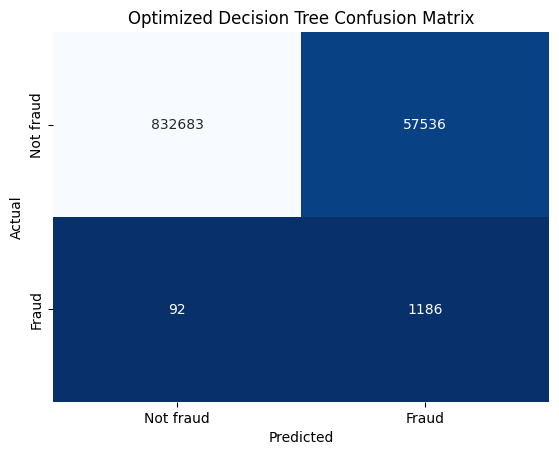

In [14]:
# evaluate the decision tree model
dt_model2_ypred = model_evaluation_function(model=dt_model2, X_test=X_test, y_test=y_test, confusion_matrix_title='Optimized Decision Tree')

In [15]:
propensities = dt_model2.predict_proba(X_test)[:, 1]

In [16]:
dt_fpr, dt_tpr, dt_thresh = roc_curve(y_test, propensities)

In [17]:
dt_auc_score = roc_auc_score(y_test, propensities)
dt_auc_score

0.9660363874415872

In [18]:
propensities

array([0.13541785, 0.        , 0.        , ..., 0.13541785, 0.        ,
       0.        ])

In [19]:
thresholds = pd.DataFrame({'propensities':propensities, 'actual':y_test, 'pred_at_05':dt_model2_ypred})

In [20]:
thresholds['pred_at_08'] = np.where(thresholds['propensities'] >= 0.8, 1, 0)

In [21]:
thresholds.head()

,propensities,actual,pred_at_05,pred_at_08
transaction_id,,,,
15903829,0.135418,0.0,0.0,0
22008593,0.000000,0.0,0.0,0
13029575,0.000000,0.0,0.0,0
20126929,0.000000,0.0,0.0,0
15664405,0.000000,0.0,0.0,0


In [22]:
conf_mat_08 = confusion_matrix(thresholds['actual'], thresholds['pred_at_08'])

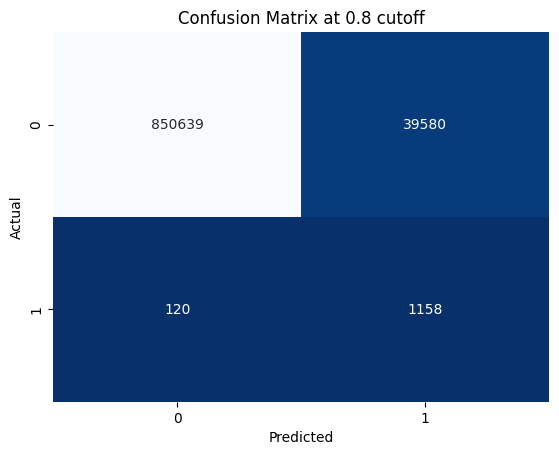

In [23]:
# show the confusion matrix in a heat map
sns.heatmap(conf_mat_08, annot=True, fmt="d", cmap='Blues_r', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix at 0.8 cutoff')
plt.show()

In [24]:
# create function to calculate model metrics
def model_metrics(tn:int, fp:int, fn:int, tp:int, cutoff:float = 0.5):
    '''
    Calculate model metrics (PCC,error rates, precision, sensitvity, and specificity

    Args:
    tn: True negatives
    fp: False positives
    fn: False negatives
    tp: True positives
    cutoff: The cutoff value of the model being evaluated; default is 0.5

    Returns:
    Dictionary of model metrics
    '''
    metrics = {}
    metrics['pcc'] = (tn + tp) / (tn + fp + fn + tp)
    metrics['false_alarm_rate'] = fp / (tn + fp)
    metrics['false_dismissal_rate'] = fn / (fn + tp)
    metrics['precision'] = tp / (tp + fp)
    metrics['sensitivity'] = tp / (tp + fn)
    metrics['specificity'] = tn / (tn + fp)
    print(f"""At cutoff value of {cutoff}:\n
          The PCC is {metrics['pcc']:.4f}\n
          The false alarm rate is {metrics['false_alarm_rate']:.4f}\n
          The false dismissal rate is {metrics['false_dismissal_rate']:.4f}\n
          The precision is {metrics['precision']:.4f}\n
          The sensitivity is {metrics['sensitivity']:.4f} and\n
          The specificity is {metrics['specificity']:.4f}""")
    return metrics

In [25]:
# calculate model metrics at 0.25 cutoff
metrics_025 = model_metrics(tn=conf_mat_08[0][0],
                            fp= conf_mat_08[0][1],
                            fn=conf_mat_08[1][0],
                            tp=conf_mat_08[1][1],
                            cutoff=0.25)

At cutoff value of 0.25:

          The PCC is 0.9555

          The false alarm rate is 0.0445

          The false dismissal rate is 0.0939

          The precision is 0.0284

          The sensitivity is 0.9061 and

          The specificity is 0.9555


In [27]:
import joblib
joblib.dump(dt_model2, 'models/decision_tree.pkl')

['models/decision_tree.pkl']

In [28]:
pd.DataFrame({'training_set':X_train.index.tolist()}).to_csv('training_set.csv', index=False)

In [32]:
import tensorflow.keras as keras

In [ ]:
model_nn = keras.models.Sequential([
    keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'recall'])

history = model_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

c:\Users\user\anaconda3\envs\ucalgary\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
111438/111438 ━━━━━━━━━━━━━━━━━━━━ 604s 5ms/step - accuracy: 0.9978 - loss: 3.3321 - recall: 2.0380e-05 - val_accuracy: 0.9986 - val_loss: 0.0108 - val_recall: 0.0000e+00
Epoch 2/10
 72660/111438 ━━━━━━━━━━━━━━━━━━━━ 3:22 5ms/step - accuracy: 0.9984 - loss: 0.0347 - recall: 0.0000e+00

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97    890219
         1.0       0.02      0.93      0.04      1278

    accuracy                           0.94    891497
   macro avg       0.51      0.93      0.50    891497
weighted avg       1.00      0.94      0.97    891497


Evaluation metrics:
The PCC is 0.9354
The false alarm rate is 0.0646
The false dismissal rate is 0.0720
The precision is 0.0202
The sensitivity is 0.9280 and
The specificity is 0.9354


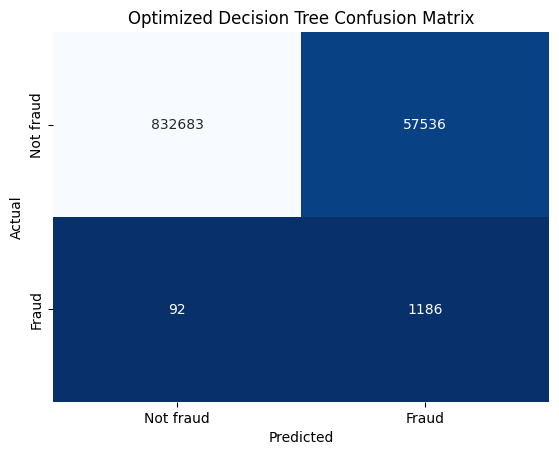

In [ ]:
# evaluate the decision tree model
model_nn_ypred = model_evaluation_function(model=model_nn, X_test=X_test, y_test=y_test, confusion_matrix_title='Neural Net')

In [ ]:
# Define hyperparameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [5, 10, 15, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 3, 5],  
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}
# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=seed)

# Perform Grid Search with 5-fold Cross Validation
dt_grid_search = RandomizedSearchCV(dt, dt_param_grid, cv=5, scoring='recall')
dt_grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_dt = dt_grid_search.best_estimator_

# Display the best parameters
print("Best Parameters:", dt_grid_search.best_params_)

Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': 'balanced'}


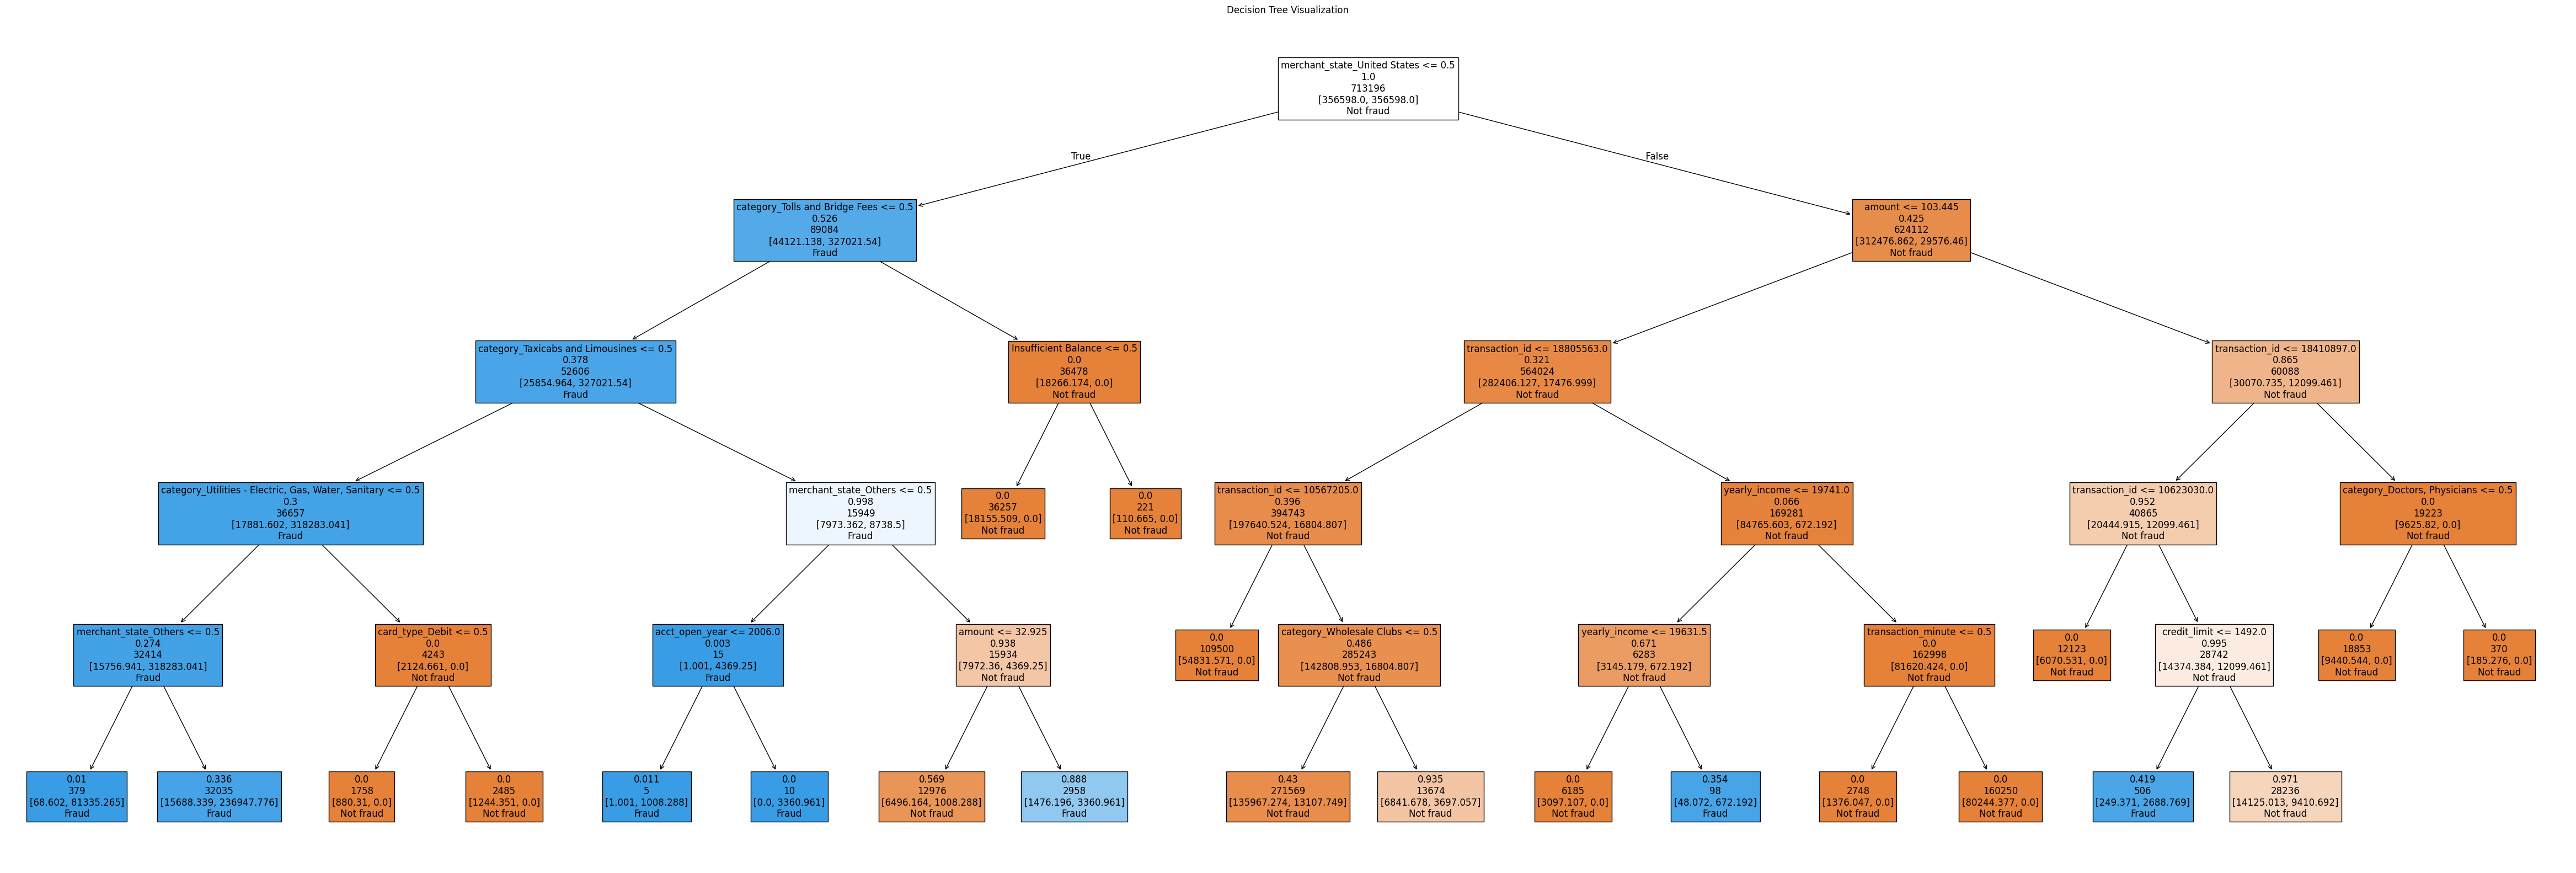

In [27]:
plt.figure(figsize=(60, 20))
plot_tree(best_dt, feature_names=X_train.columns, class_names=["Not fraud", "Fraud"], label='none', filled=True, fontsize=12)
plt.title("Decision Tree Visualization")
#plt.savefig('optimizedDecisionTree', dpi = 300)
plt.show()

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98    178028
         1.0       0.03      0.90      0.05       272

    accuracy                           0.95    178300
   macro avg       0.51      0.92      0.51    178300
weighted avg       1.00      0.95      0.97    178300


Evaluation metrics:
The PCC is 0.9515
The false alarm rate is 0.0484
The false dismissal rate is 0.1029
The precision is 0.0275
The sensitivity is 0.8971 and
The specificity is 0.9516


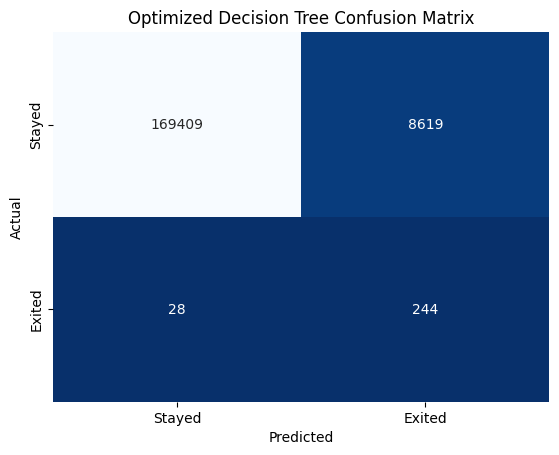

In [28]:
# evaluate the decision tree model
model_evaluation_function(model=best_dt, X_test=X_test, y_test=y_test, confusion_matrix_title='Optimized Decision Tree')

In [ ]:
# 3. Initialize a weak learner (a decision stump here)
weak_learner = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)

# 4. Create and train the AdaBoost classifier
ada_clf = AdaBoostClassifier(estimator=weak_learner,
                             n_estimators=50,
                             learning_rate=1.0,
                             random_state=42,
                             algorithm='SAMME')
ada_clf.fit(X_train, y_train)

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97    890219
         1.0       0.02      0.93      0.04      1278

    accuracy                           0.94    891497
   macro avg       0.51      0.93      0.50    891497
weighted avg       1.00      0.94      0.97    891497


Evaluation metrics:
The PCC is 0.9356
The false alarm rate is 0.0644
The false dismissal rate is 0.0720
The precision is 0.0203
The sensitivity is 0.9280 and
The specificity is 0.9356


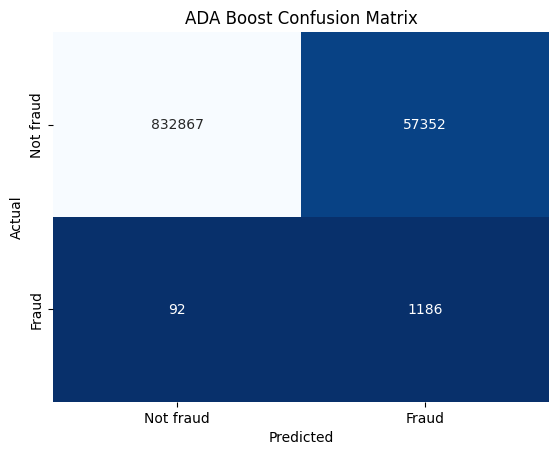

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# evaluate the decision tree model
model_evaluation_function(model=ada_clf, X_test=X_test, y_test=y_test, confusion_matrix_title='ADA Boost')

In [28]:
y_train.value_counts()

target
0.0    3560597
1.0       5388
Name: count, dtype: int64

In [29]:
3560597/5388

660.8383444691908

In [32]:
import xgboost as xgb
from xgboost import XGBClassifier

# 3. Create and train an XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100,
                        learning_rate=0.1,
                        max_depth=3,
                        use_label_encoder=False,  # modern versions of xgboost
                        eval_metric='logloss',    # required for newer xgboost versions
                        random_state=42,
                        scale_pos_weight = 99)
xgb_clf.fit(X_train, y_train)

c:\Users\user\anaconda3\envs\ucalgary\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:58:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    890219
         1.0       0.08      0.89      0.15      1278

    accuracy                           0.99    891497
   macro avg       0.54      0.94      0.57    891497
weighted avg       1.00      0.99      0.99    891497


Evaluation metrics:
The PCC is 0.9859
The false alarm rate is 0.0140
The false dismissal rate is 0.1103
The precision is 0.0837
The sensitivity is 0.8897 and
The specificity is 0.9860


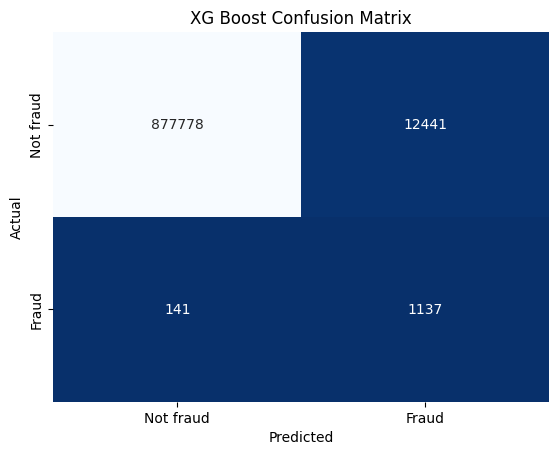

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
# evaluate the decision tree model
model_evaluation_function(model=xgb_clf, X_test=X_test, y_test=y_test, confusion_matrix_title='XG Boost')

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95    178028
         1.0       0.01      0.89      0.03       272

    accuracy                           0.90    178300
   macro avg       0.51      0.90      0.49    178300
weighted avg       1.00      0.90      0.95    178300


Evaluation metrics:
The PCC is 0.9019
The false alarm rate is 0.0981
The false dismissal rate is 0.1066
The precision is 0.0137
The sensitivity is 0.8934 and
The specificity is 0.9019


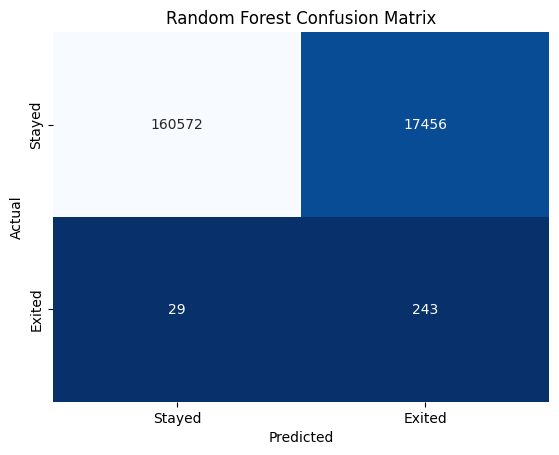

In [ ]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_split=5, min_samples_leaf=1, criterion='gini',
                                  class_weight='balanced_subsample', random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest Model
model_evaluation_function(rf_model, X_test, y_test, confusion_matrix_title='Random Forest')